In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [2]:
from ruc import (cptp_map, next_step, tensor_trace, trace_square, matrix_to_tensor, 
                        tensor_to_matrix, random_ρ, conserving_gates, random_state, inner_product)

## Conserving circuit simulation

In [3]:
purities = []
depths = np.arange(5, 10)
for d in depths:
    
    print("depth: ", d)
    ρ = random_ρ(2, d - 1)
    purity_trace = np.array([])
    eigenvalues = np.array([])

    for step in range(1000):
        purity_trace = np.append(purity_trace, trace_square(ρ))
        eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
        ρ = cptp_map(ρ, conserving_gates(d))
    
    purities.append(np.mean(purity_trace))

depth:  5
depth:  6
depth:  7
depth:  8
depth:  9


/Users/austenlamacraft/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


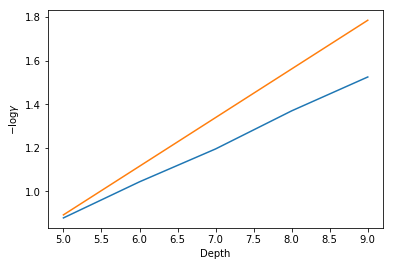

In [4]:
plt.plot(depths, -np.log(purities))
plt.plot(depths, (depths - 1) * np.log(5/4))
plt.xlabel("Depth")
plt.ylabel("$-\log\gamma$");

In [16]:
np.save("conserving_purities", purities)

Fits nicely with the predicted $(4/5)^t$ behaviour of the purity!

## Purity from Trajectories

Now we try it the second way using the relationship

$$
\gamma = \mathrm tr\left[\rho_A^2\right] = \mathbb{E}|\langle\psi_{x_1:x_N}|\psi_{y_1:y_N}\rangle|^2
$$

where $|\psi_{x_1:x_N}\rangle$ represents a normalized ancilla state arising from the trajectory $x_1:x_N$, where each step of the trajetory consists of a pair $x_j=(x^{(1)}_j, x^{(2)}_{j})$, where $x^{(1,2)}_j\in 1,\ldots q$. It is important that the trajectories are sampled from the probabilites corresponding to the ancilla states followed.

__Note__ that this way requires one extra unitary as we don't do the sum over $x_j$.

__Opportunity__ to parallelize as one just needs to gather the inner products across trajectories

In [19]:
import time

In [20]:
purities_traj = []
variances = []
depths = np.arange(5, 19)
for d in depths:
    
    print("Depth: ", d)
    print(time.ctime())
    state1 = random_state(q, d - 1)
    state2 = state1
    purity_traj = np.array([])

    for step in range(1000):
        purity_traj = np.append(purity_traj, np.abs(inner_product(state1, state2))**2)
        gates = conserving_gates(d) 
        probs1, states1 = next_step(state1, gates)
        probs2, states2 = next_step(state2, gates)
        state1 = states1[np.random.choice(range(4), p=probs1)]
        state2 = states2[np.random.choice(range(4), p=probs2)]
    
    purities_traj.append(np.mean(purity_traj))
    variances.append(np.var(purity_traj))


Depth:  5
Fri Feb 15 16:20:25 2019
Depth:  6
Fri Feb 15 16:20:26 2019
Depth:  7
Fri Feb 15 16:20:27 2019
Depth:  8
Fri Feb 15 16:20:29 2019
Depth:  9
Fri Feb 15 16:20:30 2019
Depth:  10
Fri Feb 15 16:20:33 2019
Depth:  11
Fri Feb 15 16:20:37 2019
Depth:  12
Fri Feb 15 16:20:44 2019
Depth:  13
Fri Feb 15 16:21:00 2019
Depth:  14
Fri Feb 15 16:21:33 2019
Depth:  15
Fri Feb 15 16:22:42 2019
Depth:  16
Fri Feb 15 16:25:08 2019
Depth:  17
Fri Feb 15 16:30:16 2019
Depth:  18
Fri Feb 15 16:41:30 2019


In [23]:
np.save("conserving_traj_purity", purities_traj)
np.save("conserving_traj_purity_vars", variances)

## Plotting results

In [17]:
purities_traj = np.load("conserving_traj_purity.npy")
variances = np.load("conserving_traj_purity_vars.npy")
purities = np.load("conserving_purities.npy")

/Users/austenlamacraft/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


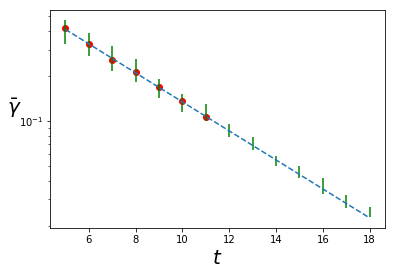

In [74]:
depths = np.arange(5,12)
plt.scatter(depths, purities, marker='o', color='r')
depths = np.arange(5,19)
plt.errorbar(depths, purities_traj, yerr=variances, linestyle="None", color='g')
plt.yscale("log")
# plt.semilogy(depths, purities_traj, marker='x')
plt.plot(depths, (4/5)**(depths - 1), linestyle="--")
plt.xlabel("$t$", fontsize=20)
plt.ylabel(r"$\bar \gamma$", fontsize=20, rotation=0);
plt.savefig("trajectory_purity.png")